In [2]:
import sys # check if the correct .venv in activated.
print(sys.executable)


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/bin/python


In [3]:
# importing the packages
import pandas as pd
import json
import requests

In [4]:
# Loading the data into the dataframes
dt_tag = pd.read_csv('data/tag.csv')
dt_rating = pd.read_csv('data/rating.csv')
dt_movie = pd.read_csv('data/movie.csv')
dt_link = pd.read_csv('data/link.csv')  
dt_genome_scores = pd.read_csv('data/genome_scores.csv')
dt_genome_tags = pd.read_csv('data/genome_tags.csv')  

In [11]:
import numpy as np

# Function to count empty strings and NaNs
def count_missing_values(df, name):
    empty_strings = (df == '').sum()
    missing_values = df.isnull().sum()
    total_missing = empty_strings + missing_values
    print(f'{name} missing or empty values per column:')
    print(total_missing)
    # Replace empty strings with NaN and drop rows with any NaN
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)
    print(f'{name} shape after dropping missing values: {df.shape}\n')

# Apply the function to each dataframe
count_missing_values(dt_tag, 'dt_tag')
count_missing_values(dt_rating, 'dt_rating')
count_missing_values(dt_movie, 'dt_movie')
count_missing_values(dt_link, 'dt_link')
count_missing_values(dt_genome_scores, 'dt_genome_scores')
count_missing_values(dt_genome_tags, 'dt_genome_tags')

dt_tag missing or empty values per column:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
dt_tag shape after dropping missing values: (465548, 4)

dt_rating missing or empty values per column:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
dt_rating shape after dropping missing values: (20000263, 4)

dt_movie missing or empty values per column:
movieId    0
title      0
genres     0
dtype: int64
dt_movie shape after dropping missing values: (27278, 3)

dt_link missing or empty values per column:
movieId      0
imdbId       0
tmdbId     252
dtype: int64
dt_link shape after dropping missing values: (27026, 3)

dt_genome_scores missing or empty values per column:
movieId      0
tagId        0
relevance    0
dtype: int64
dt_genome_scores shape after dropping missing values: (11709768, 3)

dt_genome_tags missing or empty values per column:
tagId    0
tag      0
dtype: int64
dt_genome_tags shape after dropping missing values: (1128, 2)


#### **3. TMDb API Setup**

- **API Key**: Go to [TMDb](https://www.themoviedb.org/) to sign up for an account and generate an API key.
- **Base URL**: The base URL for the API is `https://api.themoviedb.org/3`.

In [1]:
api_key = "6910dd2154b064df140c6e1ec1f48d61"


## Check Movie Existence in TMDb API

This notebook checks if each movie in our `dt_movie` dataset exists in the TMDb API. We have 27,278 movies, and some already have a `tmdbId` in the `dt_link` dataset. We'll:

### Steps
1. Load the data.
2. Label movies that does not exist in the tmdb API.
3. Save the results.


In [39]:
import time

# Assume dt_movie and dt_link are already loaded DataFrames
# Step 1: Merge dt_movie with dt_link to bring in `tmdbId`
merged_data = pd.merge(dt_movie, dt_link[['movieId', 'tmdbId']], on='movieId', how='left')

# Step 2: Separate movies with and without tmdbId
with_tmdb_id = merged_data[merged_data['tmdbId'].notna()]
without_tmdb_id = merged_data[merged_data['tmdbId'].isna()]

# Initialize results DataFrame
results = pd.DataFrame(columns=['movieId', 'title', 'exists_in_tmdb'])

# Helper function to check if a movie exists in TMDb by its TMDb ID
def check_movie_by_id(tmdb_id):
    url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={api_key}'
    response = requests.get(url)
    return response.status_code == 200  # Status 200 means movie found

# Helper function to check if a movie exists in TMDb by its title
def check_movie_by_title(title):
    url = f'https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={title}'
    response = requests.get(url)
    data = response.json()
    return data['total_results'] > 0 if 'total_results' in data else False

# Step 3: Check movies with `tmdbId` directly
print("Checking movies with known tmdbId...")
for i, row in with_tmdb_id.iterrows():
    exists = check_movie_by_id(row['tmdbId'])
    print(i)
    # Using pd.concat to add new row to results
    results = pd.concat([results, pd.DataFrame([{'movieId': row['movieId'], 'title': row['title'], 'exists_in_tmdb': exists}])], ignore_index=True)
    time.sleep(0.1)  # Avoid hitting rate limit

# Step 4: Check movies without `tmdbId` by title
print("Checking movies by title for those without tmdbId...")
for i, row in without_tmdb_id.iterrows():
    exists = check_movie_by_title(row['title'])
    print(i)
    # Using pd.concat to add new row to results
    results = pd.concat([results, pd.DataFrame([{'movieId': row['movieId'], 'title': row['title'], 'exists_in_tmdb': exists}])], ignore_index=True)
    time.sleep(0.1)  # Avoid hitting rate limit

# Step 5: Save results to CSV for further analysis
results.to_csv('movie_existence_results.csv', index=False)

# Summary statistics
print(f"Total movies checked: {len(results)}")
print(f"Movies found in TMDb: {results['exists_in_tmdb'].sum()}")
print(f"Movies not found in TMDb: {len(results) - results['exists_in_tmdb'].sum()}")


Checking movies with known tmdbId...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
2

## Remove Movies that Exist in Kaggle Dataset but Not in TMDb API (534 Movies)

1. **Load the `movie_existence_results.csv`**: This file contains each movie's `movieId` along with a boolean column `exists_in_tmdb`. We'll use this information to identify the movies not found in TMDb.
2. **Filter Movies Across All Tables**: For each relevant table (`dt_tag`, `dt_rating`, `dt_movie`, `dt_link`, and `dt_genome_scores`), we'll exclude rows associated with these missing `movieId`s.
3. **Save or Display Results**: We’ll save each cleaned DataFrame to a new CSV file or display their shapes to verify the filtering process.



In [13]:
import pandas as pd

# Load the movie existence results to get the list of movies not found in TMDb
movie_existence_results = pd.read_csv('movie_existence_results.csv')
not_found_movies = movie_existence_results[movie_existence_results['exists_in_tmdb'] == False]['movieId'].tolist()

# Filter each DataFrame to exclude movies not found in TMDb
dt_tag_cleaned = dt_tag[~dt_tag['movieId'].isin(not_found_movies)]
dt_rating_cleaned = dt_rating[~dt_rating['movieId'].isin(not_found_movies)]
dt_movie_cleaned = dt_movie[~dt_movie['movieId'].isin(not_found_movies)]
dt_link_cleaned = dt_link[~dt_link['movieId'].isin(not_found_movies)]
dt_genome_scores_cleaned = dt_genome_scores[~dt_genome_scores['movieId'].isin(not_found_movies)]
dt_genome_tags_cleaned = dt_genome_tags.copy()  # No need to filter genome_tags

# Display the shapes of the cleaned DataFrames to confirm the filtering
print("dt_tag_cleaned shape:", dt_tag_cleaned.shape)
print("dt_rating_cleaned shape:", dt_rating_cleaned.shape)
print("dt_movie_cleaned shape:", dt_movie_cleaned.shape)
print("dt_link_cleaned shape:", dt_link_cleaned.shape)
print("dt_genome_scores_cleaned shape:", dt_genome_scores_cleaned.shape)
print("dt_genome_tags_cleaned shape:", dt_genome_tags_cleaned.shape)

# Optionally, save the cleaned DataFrames back to CSV for future use
dt_tag_cleaned.to_csv('dt_tag_cleaned.csv', index=False)
dt_rating_cleaned.to_csv('dt_rating_cleaned.csv', index=False)
dt_movie_cleaned.to_csv('dt_movie_cleaned.csv', index=False)
dt_link_cleaned.to_csv('dt_link_cleaned.csv', index=False)
dt_genome_scores_cleaned.to_csv('dt_genome_scores_cleaned.csv', index=False)
dt_genome_tags_cleaned.to_csv('dt_genome_tags_cleaned.csv', index=False)


dt_tag_cleaned shape: (462004, 4)
dt_rating_cleaned shape: (19958032, 4)
dt_movie_cleaned shape: (26744, 3)
dt_link_cleaned shape: (26735, 3)
dt_genome_scores_cleaned shape: (11620656, 3)
dt_genome_tags_cleaned shape: (1128, 2)


#### **4. Fetch Popular Movies**

Let’s start by fetching a list of popular movies from the TMDb API. Each movie entry includes basic details like title, release date, and rating.

In [7]:
# Choose a sample movie_id; here we use 550, which corresponds to the movie "Fight Club"
sample_movie_id = 550

# Construct the API request URL
url = f'https://api.themoviedb.org/3/movie/{sample_movie_id}?api_key={api_key}'

# Send the request to TMDb API
response = requests.get(url)

# Check if the response is successful
if response.status_code == 200:
    # Parse the JSON response
    movie_data = response.json()
    
    # Display all available fields (features/columns) in the movie data
    print("Available fields in TMDb API for the sample movie (movie_id = 1):")
    for key in movie_data.keys():
        print(key)
else:
    print(f"Failed to fetch data. Status code: {response.status_code}, Message: {response.text}")


Available fields in TMDb API for the sample movie (movie_id = 1):
adult
backdrop_path
belongs_to_collection
budget
genres
homepage
id
imdb_id
origin_country
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


#### **5. Fetch Detailed Movie Information**

Once we have a list of popular movies, we can fetch detailed information for each movie by using its unique `movie_id`.

In [ ]:
import pandas as pd
import requests
import time

# Load the cleaned CSV files
dt_movie = pd.read_csv('dt_movie_cleaned.csv')   # Contains movieId, title, genres
dt_link = pd.read_csv('dt_link_cleaned.csv')     # Contains movieId, imdbId, tmdbId
dt_genome_scores = pd.read_csv('dt_genome_scores_cleaned.csv')  # Contains movieId, tagId, relevance
dt_genome_tag = pd.read_csv('dt_genome_tags_cleaned.csv')       # Contains tagId, tag
dt_rating = pd.read_csv('dt_rating_cleaned.csv')  # Contains userId, movieId, rating, timestamp

# Merge dt_movie with dt_link to include `tmdbId`
merged_data = pd.merge(dt_movie, dt_link[['movieId', 'tmdbId']], on='movieId', how='left')

# Filter for movies that have a valid `tmdbId`
movies_with_tmdbId = merged_data[merged_data['tmdbId'].notna()]

# Prepare an empty list to collect additional features
additional_features = []

# Helper function to fetch movie details from TMDb
def fetch_tmdb_movie_data(tmdb_id):
    url = f'https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

# Loop over movies with `tmdbId` and fetch additional features from TMDb
for _, row in movies_with_tmdbId.iterrows():
    tmdb_id = int(row['tmdbId'])
    movie_data = fetch_tmdb_movie_data(tmdb_id)
    
    if movie_data:
        # Append relevant fields to the list
        print(f"Fetching data for movieId: {row['movieId']}, tmdbId: {tmdb_id}")
        additional_features.append({
            'movieId': row['movieId'],
            'popularity': movie_data.get('popularity'),
            'vote_average': movie_data.get('vote_average'),
            'vote_count': movie_data.get('vote_count'),
            'runtime': movie_data.get('runtime'),
            'release_date': movie_data.get('release_date'),
            'production_countries': [country['name'] for country in movie_data.get('production_countries', [])],
            'revenue': movie_data.get('revenue'),
            'budget': movie_data.get('budget'),
            'spoken_languages': [language['name'] for language in movie_data.get('spoken_languages', [])],
            'adult': movie_data.get('adult')
        })
    else:
        # Append None values if the movie data is not found
        print(f"Data not found for movieId: {row['movieId']}, tmdbId: {tmdb_id}")
        additional_features.append({
            'movieId': row['movieId'],
            'popularity': None,
            'vote_average': None,
            'vote_count': None,
            'runtime': None,
            'release_date': None,
            'production_countries': None,
            'revenue': None,
            'budget': None,
            'spoken_languages': None,
            'adult': None
        })
    
    time.sleep(0.1)  # To avoid hitting TMDb rate limits

# Convert additional features to a DataFrame
additional_features_df = pd.DataFrame(additional_features)

# Merge additional features with the movie data
final_movie_data = pd.merge(additional_features_df, dt_movie, on='movieId', how='left')

# **Select only the highest relevance tag per movie**

#### Steps to get the top 5 most relevant tags and turn them into one string #####
#sorted_genome_scores = dt_genome_scores.sort_values(by=['movieId', 'relevance'], ascending=[True, False])
#top_5_tags_per_movie = sorted_genome_scores.groupby('movieId').head(5)
#tags_with_names = pd.merge(top_5_tags_per_movie, dt_genome_tag, on='tagId', how='inner')
#tags_summary = tags_with_names.groupby('movieId')['tag'].apply(lambda x: ' | '.join(x)).reset_index()
#final_movie_data = pd.merge(final_movie_data, tags_summary[['movieId', 'tag']], on='movieId', how='left')

# Step 1: Get the highest relevance for each movieId
highest_relevance_tags = dt_genome_scores.loc[dt_genome_scores.groupby('movieId')['relevance'].idxmax()]

# Step 2: Merge with `dt_genome_tag` to get tag names for the highest relevance tags
tags_data = pd.merge(highest_relevance_tags, dt_genome_tag, on='tagId', how='inner')

# Merge the tags data with the main movie data
final_movie_data = pd.merge(final_movie_data, tags_data[['movieId', 'tag']], on='movieId', how='left')

# Save the final dataset with TMDb features and tags included
final_movie_data.to_csv('movies_with_tmdb_features_and_tags.csv', index=False)

# Display a sample of the final dataset
print(final_movie_data.head())


Fetching data for movieId: 1, tmdbId: 862
Fetching data for movieId: 2, tmdbId: 8844
   movieId  popularity  vote_average  vote_count  runtime release_date  \
0        1     134.972          8.00       18317       81   1995-10-30   
1        2      15.958          7.24       10465      104   1995-12-15   

         production_countries    revenue    budget     spoken_languages  \
0  [United States of America]  394436586  30000000            [English]   
1  [United States of America]  262821940  65000000  [English, Français]   

   adult             title                                       genres  \
0  False  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1  False    Jumanji (1995)                   Adventure|Children|Fantasy   

         tag  
0       toys  
1  adventure  


Convert genres and production countries into a list of strings.

# Feature extraction on our new csv file

In [4]:
# Load in the final_movie_data
final_movie_data = pd.read_csv('data/movies_with_tmdb_features_and_tags.csv')
# Set movietitles to movieId and title
movie_titles = final_movie_data[['movieId', 'title']]
# See how many times budget and revenue are 0 and if they should be removed and how many Tags are missing
print("Number of movies with budget 0:", final_movie_data[final_movie_data['budget'] == 0].shape[0])
print("Number of movies with revenue 0:", final_movie_data[final_movie_data['revenue'] == 0].shape[0])
print("Number of movies with missing tags:", final_movie_data['tag'].isnull().sum())

# See how many spoken languages are empty and how many different languages are spoken
print("Number of movies with empty spoken languages:", final_movie_data[final_movie_data['spoken_languages'] == '[]'].shape[0])
spoken_languages = final_movie_data['spoken_languages'].explode().dropna()
print("Number of different spoken languages:", spoken_languages.nunique())

# see how many movies are adult
print("Number of adult movies:", final_movie_data[final_movie_data['adult'] == True].shape[0])

Number of movies with budget 0: 17564
Number of movies with revenue 0: 17274
Number of movies with missing tags: 16435
Number of movies with empty spoken languages: 468
Number of different spoken languages: 1764
Number of adult movies: 3


In [5]:
final_movie_data['genres'] = final_movie_data['genres'].str.split('|')


In [6]:
import ast


final_movie_data['production_countries'] = final_movie_data['production_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

## Remove all five features since over half of the rows are 0 or missing and there are so many different languages and a lot of empty (Also only 3 adult movies)

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
# Remove all four features since over half of the rows are 0 or missing and spoken languages and adult is not useful
final_movie_data.drop(columns=['budget', 'revenue', 'tag', 'spoken_languages', 'adult'], inplace=True)
# print features to see if they were removed
print(final_movie_data.columns)

Index(['movieId', 'popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'production_countries', 'title', 'genres'],
      dtype='object')


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_5961/797093989.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')


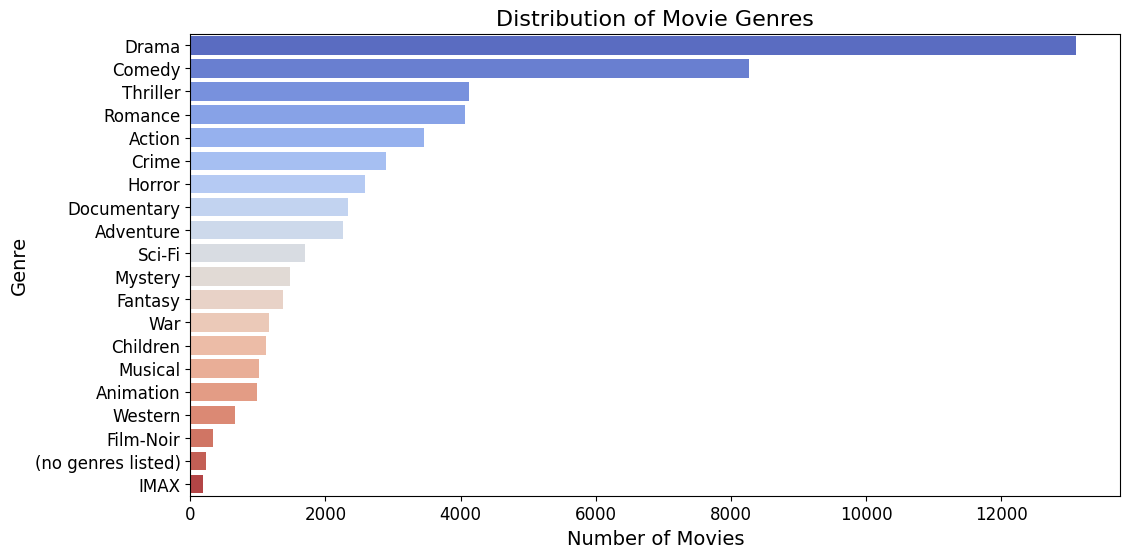

In [11]:
# Split genres and count


exploded_data = final_movie_data.explode('genres')

# Count the occurrences of each genre
genre_counts = exploded_data['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')
plt.title('Distribution of Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


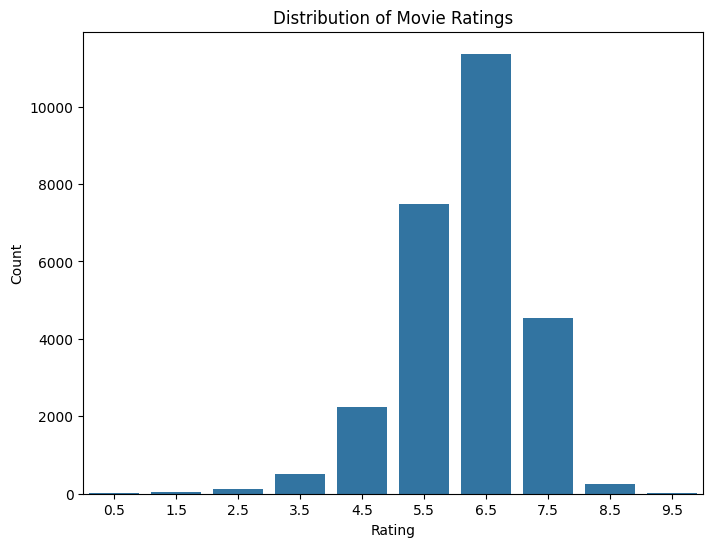

In [12]:
# Bin vote_average into intervals of 0.5
final_movie_data['vote_average_binned'] = pd.cut(final_movie_data['vote_average'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

# Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='vote_average_binned', data=final_movie_data, order=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

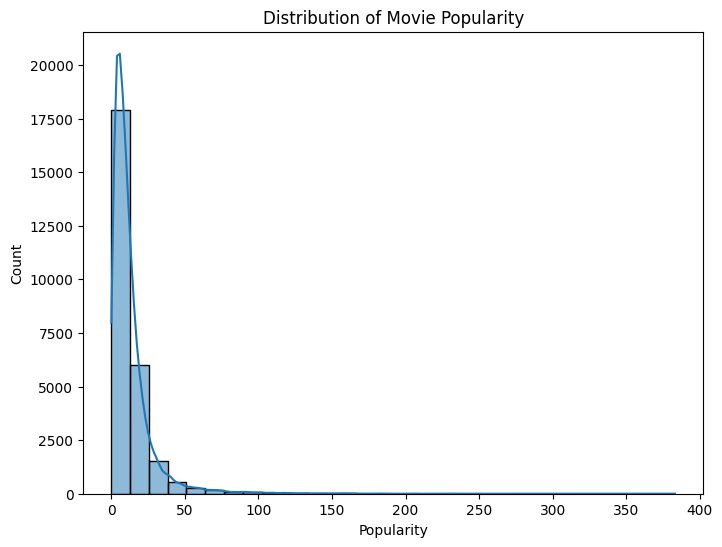

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(final_movie_data['popularity'], kde=True, bins=30)
plt.title('Distribution of Movie Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()


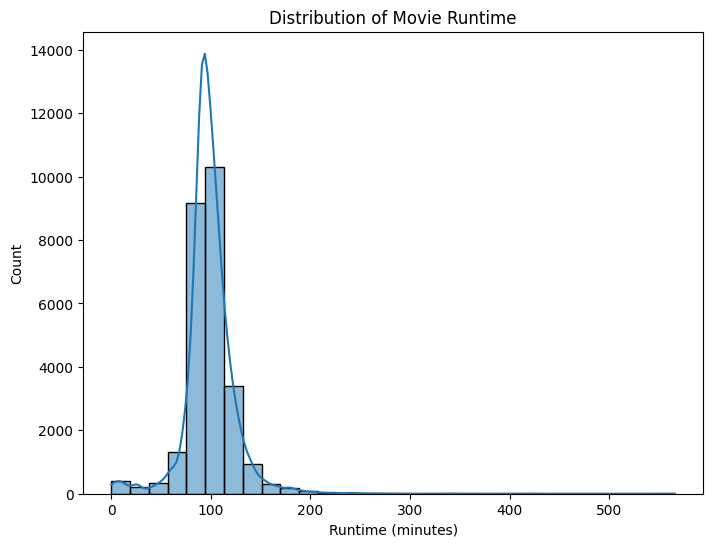

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(final_movie_data['runtime'], kde=True, bins=30)
plt.title('Distribution of Movie Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Count')
plt.show()


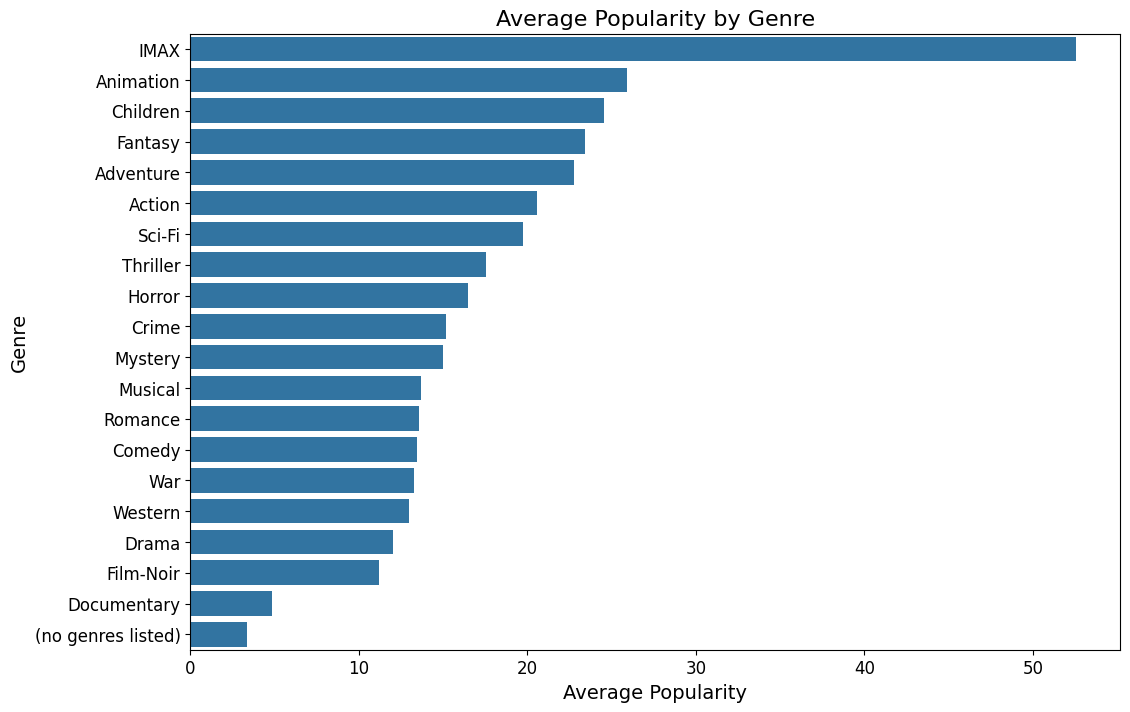

In [16]:
# Explode genres into separate rows
exploded_data = final_movie_data.explode('genres')

# Calculate the average popularity for each genre
genre_popularity = exploded_data.groupby('genres')['popularity'].mean().sort_values(ascending=False)

# Plot the top 20 genres by average popularity
plt.figure(figsize=(12, 8))  # Larger figure size
sns.barplot(x=genre_popularity.values[:20], y=genre_popularity.index[:20])  # Top 20 genres
plt.title('Average Popularity by Genre', fontsize=16)
plt.xlabel('Average Popularity', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_5961/1207561345.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')


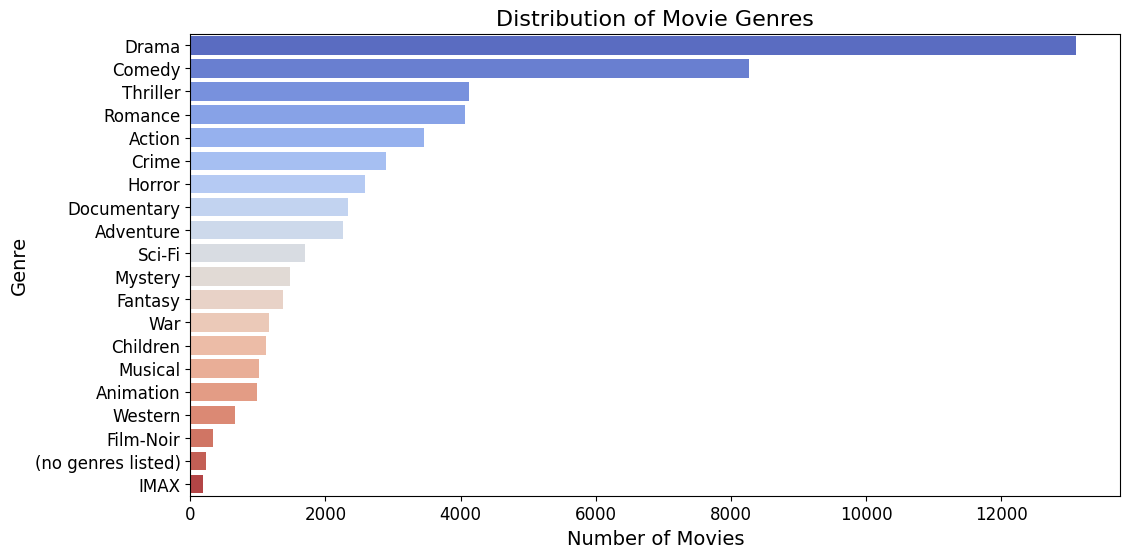

In [17]:

# Ensure 'genres' is split into lists, then explode into individual rows
exploded_data = final_movie_data.explode('genres')

# Count the occurrences of each genre
genre_counts = exploded_data['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')
plt.title('Distribution of Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


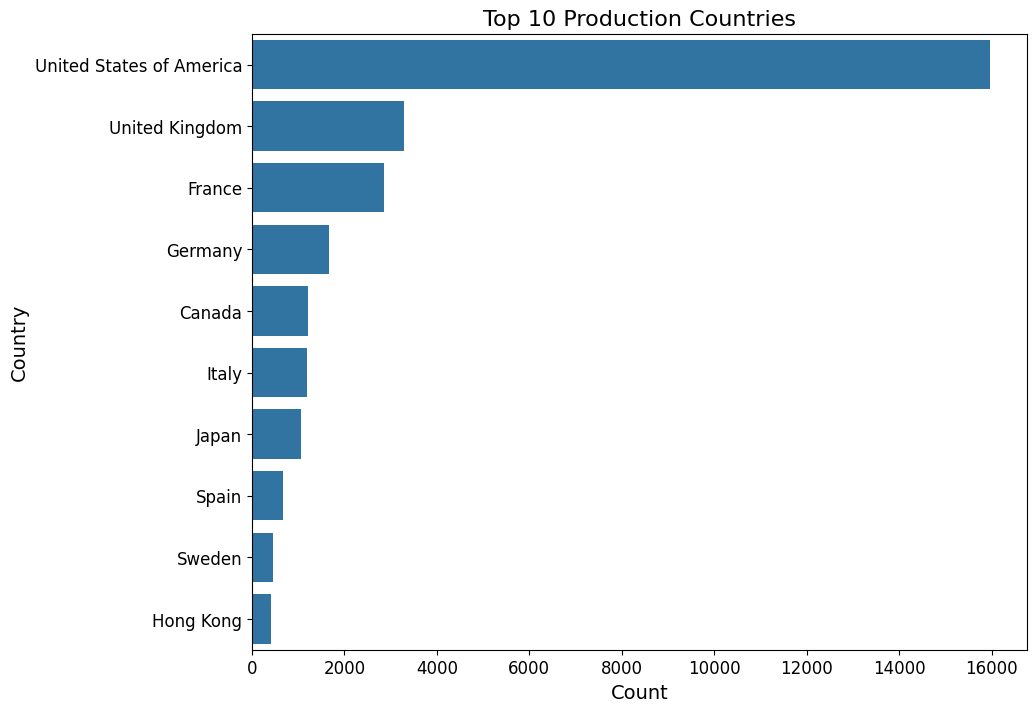

In [19]:
from collections import Counter
# Explode the production_countries column into separate rows
exploded_countries = final_movie_data.explode('production_countries')

# Count occurrences of each country
country_counts = Counter(exploded_countries['production_countries'].dropna())
top_countries = pd.DataFrame(country_counts.most_common(10), columns=['Country', 'Count'])

# Plot the top 10 production countries
plt.figure(figsize=(10, 8))  # Larger figure size for readability
sns.barplot(x='Count', y='Country', data=top_countries)
plt.title('Top 10 Production Countries', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()